In [1]:
# Import numpy, pandas for data manipulation
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None 
# Import matplotlib, seaborn for visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Import the data
weather_data = pd.read_csv('Train.csv',parse_dates=['date'], sep=',', decimal=','
                     , infer_datetime_format=True)

# Check the shape of the dataset
print(weather_data.shape)

# Select the datetime and the temperature columns
temp_df = weather_data[["date","meantemp"]]
temp_df.head(10)

(1462, 5)


,date,meantemp
0,2013-01-01,10.0
1,2013-01-02,7.4
2,2013-01-03,7.166666666666667
3,2013-01-04,8.666666666666666
4,2013-01-05,6.0
5,2013-01-06,7.0
6,2013-01-07,7.0
7,2013-01-08,8.857142857142858
8,2013-01-09,14.0
9,2013-01-10,11.0


In [2]:
temp_df.dtypes

date        datetime64[ns]
meantemp            object
dtype: object

In [3]:
temp_df.set_index("date", inplace=True)
temp_df.describe()

,meantemp
count,1462
unique,617
top,31.0
freq,18


In [4]:
temp_df.describe()

,meantemp
count,1462
unique,617
top,31.0
freq,18


In [5]:
temp_df[["meantemp"]] = temp_df[["meantemp"]].apply(pd.to_numeric)

In [6]:
temp_df.dtypes

meantemp    float64
dtype: object

In [7]:
temp_df.describe()

,meantemp
count,1462.000000
mean,25.495521
std,7.348103
min,6.000000
25%,18.857143
50%,27.714286
75%,31.305804
max,38.714286


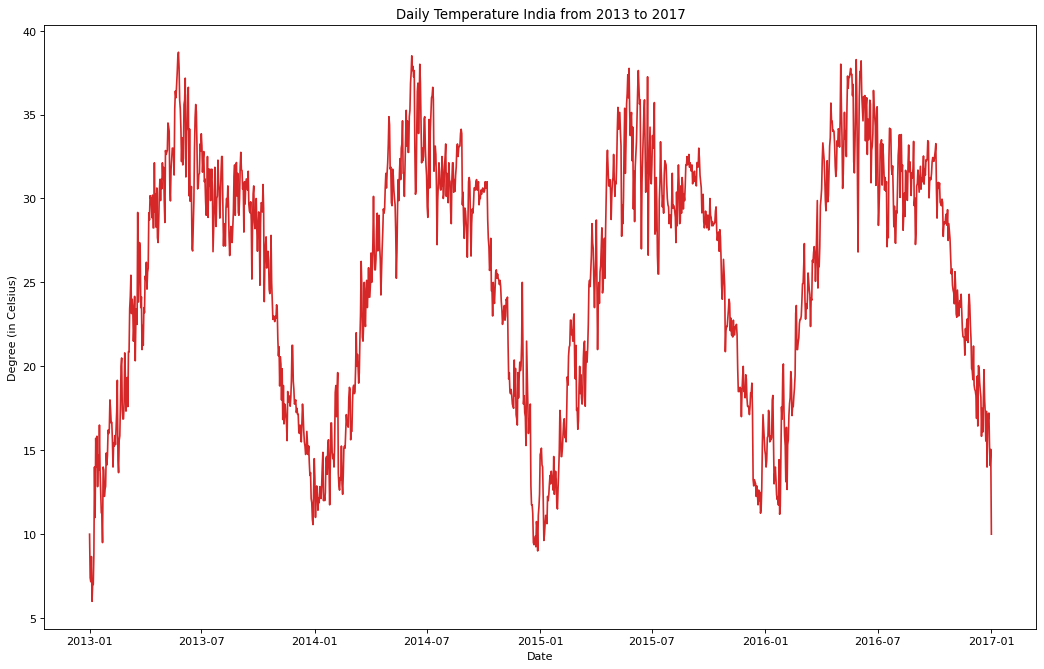

In [8]:
# Plot the daily temperature change 
plt.figure(figsize=(16,10), dpi=80)
plt.plot(temp_df.index, temp_df.meantemp, color='tab:red')
plt.gca().set(title="Daily Temperature India from 2013 to 2017", xlabel='Date', ylabel="Degree (in Celsius)")
plt.show()

<AxesSubplot:xlabel='date'>

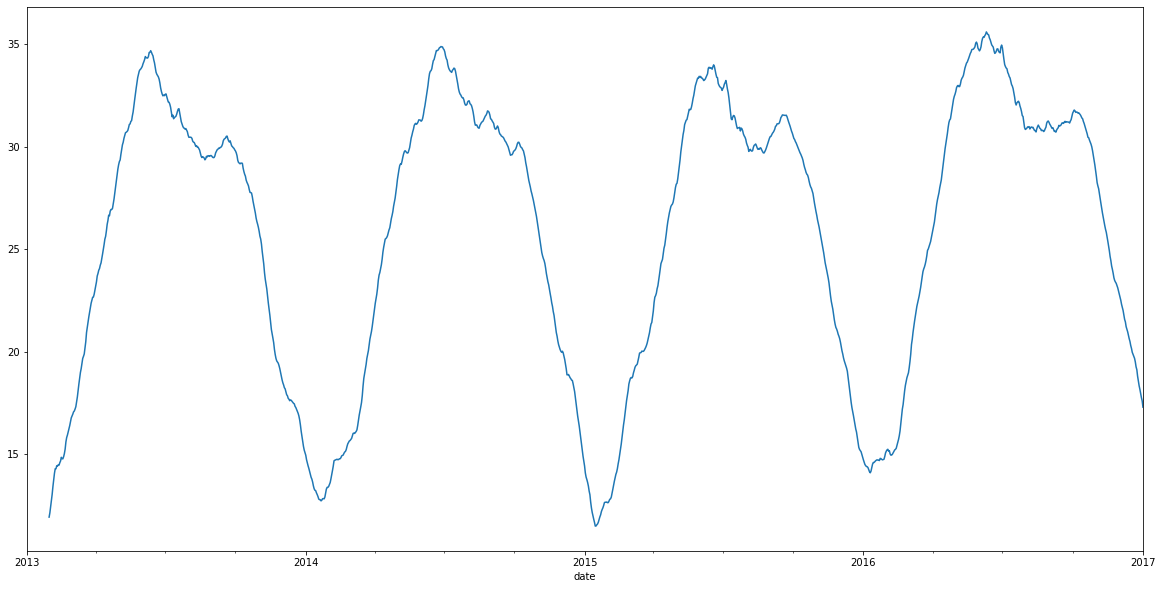

In [9]:
# Apply the Moving Average function by a subset of size 30 days.
temp_df_mean = temp_df.meantemp.rolling(window=30).mean()
temp_df_mean.plot(figsize=(20,10))

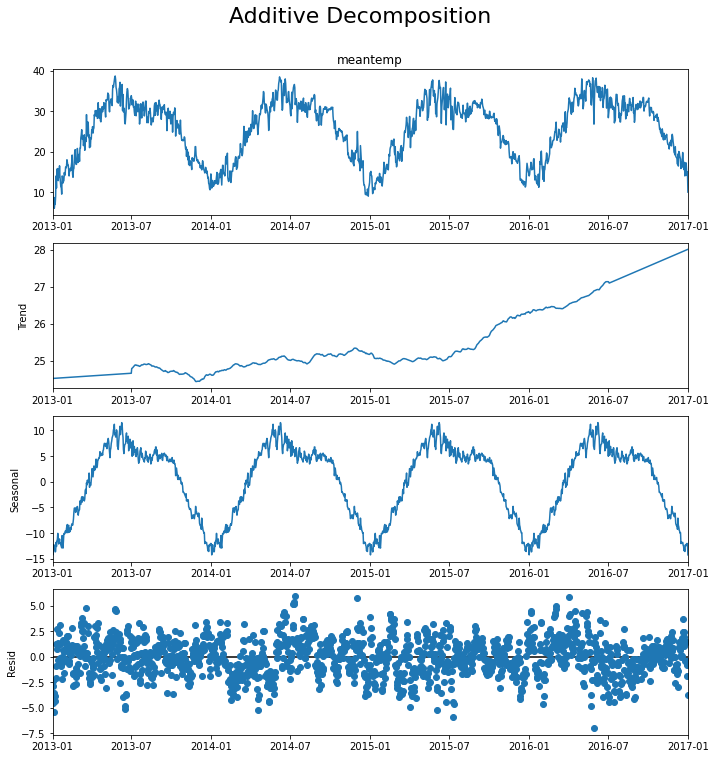

In [10]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Additive Decomposition
result_add = seasonal_decompose(temp_df.meantemp, model='additive', extrapolate_trend='freq', period=365)

# Plot
plt.rcParams.update({'figure.figsize': (10,10)})
result_add.plot().suptitle('Additive Decomposition', fontsize=22, y=1.05)
plt.show()

In [11]:
# Shift the current temperature to the next day. 
predicted_df = temp_df["meantemp"].to_frame().shift(1).rename(columns = {"meantemp": "meantemp_pred" })
actual_df = temp_df["meantemp"].to_frame().rename(columns = {"meantemp": "meantemp_actual" })

# Concatenate the actual and predicted temperature
one_step_df = pd.concat([actual_df,predicted_df],axis=1)

# Select from the second row, because there is no prediction for today due to shifting.
one_step_df = one_step_df[1:]
one_step_df.head(10)

,meantemp_actual,meantemp_pred
date,,
2013-01-02,7.400000,10.000000
2013-01-03,7.166667,7.400000
2013-01-04,8.666667,7.166667
2013-01-05,6.000000,8.666667
2013-01-06,7.000000,6.000000
2013-01-07,7.000000,7.000000
2013-01-08,8.857143,7.000000
2013-01-09,14.000000,8.857143
2013-01-10,11.000000,14.000000


In [12]:
from sklearn.metrics import mean_squared_error as MSE
from math import sqrt

# Calculate the RMSE
temp_pred_err = MSE(one_step_df.meantemp_actual, one_step_df.meantemp_pred, squared=False)
print("The RMSE is",temp_pred_err)

The RMSE is 1.6708989434164405


In [13]:
import itertools

# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [24]:
import warnings
warnings.filterwarnings("ignore") # specify to ignore warning messages
import statsmodels.api as sm
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(one_step_df.meantemp_actual,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('SARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

SARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:13719.932973918825
SARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:11854.150568604338
SARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:7586.306672269684
SARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:7499.507236441565
SARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:7590.636456669941
SARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:7576.134375164707
SARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:7500.9539501192285
SARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:7495.9164596749115
SARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:11845.228061775193
SARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:10280.474473511289
SARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:6859.9988200760745
SARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:6722.475032264426
SARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:6869.294360007221
SARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:6875.390472526155
SARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:6711.613327555308
SARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:6705.2900775787675
SARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:5640.011433154402
SARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:55

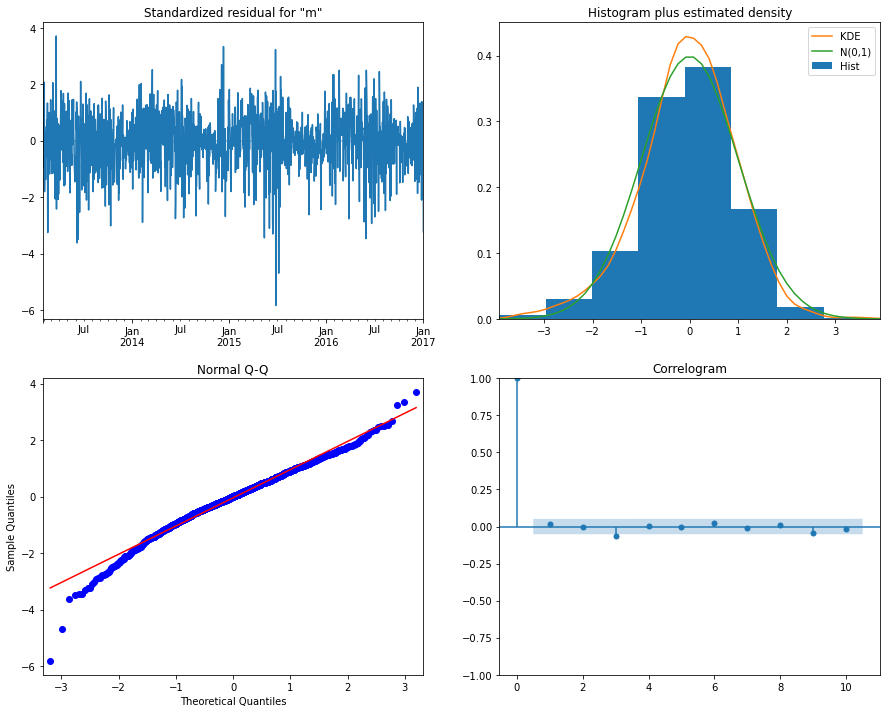

In [25]:
# Fit the SARIMAX model using optimal parameters
mod = sm.tsa.statespace.SARIMAX(one_step_df.meantemp_actual,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()
results.plot_diagnostics(figsize=(15, 12))
plt.show()

In [16]:
pred = results.get_prediction(start=pd.to_datetime('2015-08-01'),dynamic=False)
pred_ci = pred.conf_int()

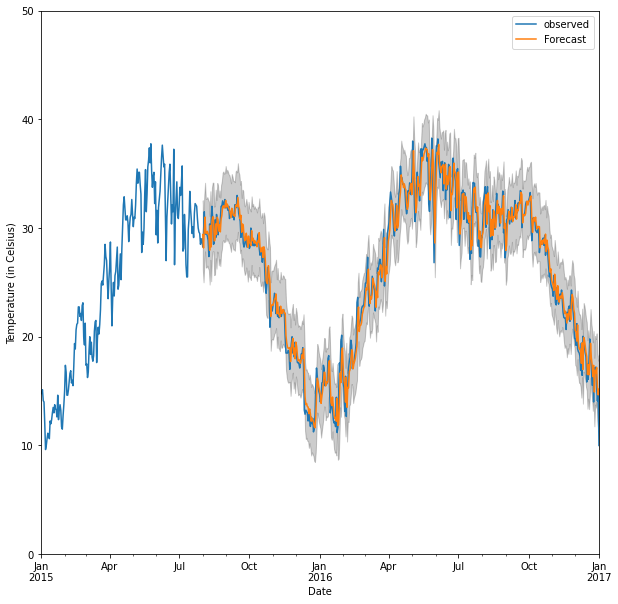

In [17]:
ax = one_step_df.meantemp_actual['2015':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='Forecast')

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('Temperature (in Celsius)')
plt.ylim([0,50])
plt.legend()
plt.show()

In [19]:
y_forecasted = pred.predicted_mean
y_truth = one_step_df.meantemp_actual['2015-08-01':]
print(y_forecasted.shape)
print(y_truth.shape)
# Compute the mean square error
mse = MSE(y_truth, y_forecasted, squared=True)
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

(520,)
(520,)
The Mean Squared Error of our forecasts is 2.17


In [20]:
pred_dynamic = results.get_prediction(start=pd.to_datetime('2015-08-01'), dynamic=True, full_results=True)
pred_dynamic_ci = pred_dynamic.conf_int()

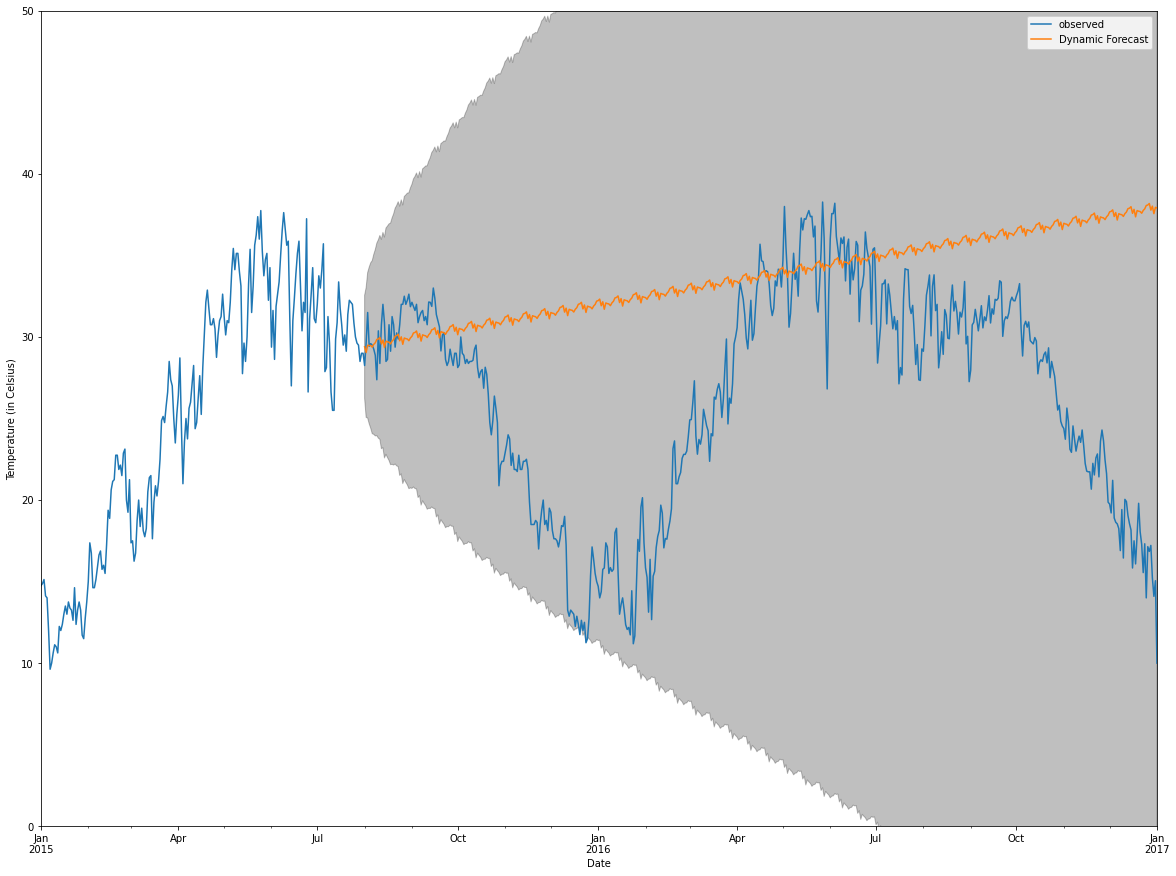

In [21]:
ax = one_step_df.meantemp_actual['2015':].plot(label='observed', figsize=(20, 15))
pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

ax.fill_between(pred_dynamic_ci.index,
                pred_dynamic_ci.iloc[:, 0],
                pred_dynamic_ci.iloc[:, 1], color='k', alpha=.25)


ax.set_xlabel('Date')
ax.set_ylabel('Temperature (in Celsius)')
plt.ylim([0,50])
plt.legend()
plt.show()

In [23]:
# Extract the predicted and true values of our time series
y_forecasted = pred_dynamic.predicted_mean
y_truth = one_step_df.meantemp_actual['2015-08-01':]

# Compute the mean square error
mse = sqrt(MSE(y_truth, y_forecasted).mean())
print('The Root Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Root Mean Squared Error of our forecasts is 10.2
